<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/csci4521_hw4_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Section 1

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
###### option 1: adding data to your drive and importing from there
from google.colab import drive
drive.mount('/content/drive/')

BASE_PATH = '/content/drive/MyDrive/CSCI4521_HW4_Dataset'
######

In [ ]:
###### option 2: dragging the data to colab and going through it here
!unzip ./skin_cancer.zip
BASE_PATH = './skin_cancer/'
######


Streaming output truncated to the last 5000 lines.
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029321_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029322_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029323_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029324_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029325_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029326_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029327_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029328_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029329_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029330_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029331_segmentation.png  
  inflating: skin_cancer/HAM10000_segmentations/ISIC_0029332_segmenta

In [ ]:
IMAGE_DIR = os.path.join(BASE_PATH, 'HAM10000_images')
MASK_DIR = os.path.join(BASE_PATH, 'HAM10000_segmentations')
METADATA_PATH = os.path.join(BASE_PATH, 'HAM10000_metadata.csv')

metadata_df = pd.read_csv(METADATA_PATH)

In [ ]:
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
#### create binary classification column for the images
malignant_map = {'mel': 1, 'bcc': 1, 'akiec': 1}
benign_map = {'nv': 0, 'bkl': 0, 'vasc': 0, 'df': 0}
metadata_df['binary_label'] = metadata_df['dx'].map(malignant_map).fillna(metadata_df['dx'].map(benign_map)).astype(int)

#### create multiclass classification column for the images
class_to_idx = {cls: i for i, cls in enumerate(metadata_df['dx'].unique())}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}
metadata_df['multiclass_label'] = metadata_df['dx'].map(class_to_idx)

#### create image and mask path column for the images
image_paths = {os.path.splitext(f)[0]: os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)}
mask_paths = {os.path.splitext(f)[0].replace('_segmentation', ''): os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)}

metadata_df['image_path'] = metadata_df['image_id'].map(image_paths)
metadata_df['mask_path'] = metadata_df['image_id'].map(mask_paths)
metadata_df = metadata_df.dropna(subset=['image_path', 'mask_path'])

In [ ]:
metadata_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,binary_label,multiclass_label,image_path,mask_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0,0,./skin_cancer/HAM10000_images/ISIC_0027419.jpg,./skin_cancer/HAM10000_segmentations/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0,0,./skin_cancer/HAM10000_images/ISIC_0025030.jpg,./skin_cancer/HAM10000_segmentations/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0,0,./skin_cancer/HAM10000_images/ISIC_0026769.jpg,./skin_cancer/HAM10000_segmentations/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0,0,./skin_cancer/HAM10000_images/ISIC_0025661.jpg,./skin_cancer/HAM10000_segmentations/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0,0,./skin_cancer/HAM10000_images/ISIC_0031633.jpg,./skin_cancer/HAM10000_segmentations/ISIC_0031...


In [ ]:
class HAM10000Dataset(Dataset):
    def __init__(self, df, use_mask=True, img_size=128, is_train=False, augmentation=None):
        self.df = df
        self.use_mask = use_mask
        self.img_size = img_size
        self.is_train = is_train
        self.augmentation = augmentation

        self.resize = transforms.Resize((img_size, img_size))
        self.to_tensor = transforms.ToTensor()

        self.color_jitter = None
        self.hflip = None
        self.rotation_degrees = None

        if self.is_train and augmentation:
            self.color_jitter = augmentation.get('color_jitter')
            self.hflip = augmentation.get('hflip', False)
            self.rotation_degrees = augmentation.get('rotation')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        mask_path = row['mask_path']
        binary_label = torch.tensor(row['binary_label'], dtype=torch.float32)
        multiclass_label = torch.tensor(row['multiclass_label'], dtype=torch.long)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.resize(image)
        mask = self.resize(mask)

        if self.is_train:
            if self.hflip and torch.rand(1) < 0.5:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)

            if self.rotation_degrees:
                angle = transforms.RandomRotation.get_params(self.rotation_degrees)
                image = transforms.functional.rotate(image, angle)
                mask = transforms.functional.rotate(mask, angle)

        if self.is_train and self.color_jitter:
            image = self.color_jitter(image)

        image = self.to_tensor(image)
        mask = self.to_tensor(mask)

        if self.use_mask:
            mask = (mask > 0.5).float()
            image = image * mask

        return image, binary_label, multiclass_label, row['image_id']

In [ ]:
# useful functions

# turn the tensor dataset into numpy for SKLearn
def preprocess_for_sklearn(df, img_size):
  X = []
  y = []

  transform_q2 = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor()
  ])

  for _, row in df.iterrows():
      image = Image.open(row['image_path']).convert("RGB")
      mask = Image.open(row['mask_path']).convert("L")

      image_tensor = transform_q2(image)
      mask_tensor = transform_q2(mask)

      mask_tensor = (mask_tensor > 0.5).float()
      masked_image = image_tensor * mask_tensor

      X.append(masked_image.numpy().flatten())
      y.append(row['binary_label'])

  return np.array(X), np.array(y)

# helper function to visualiza an image
def imshow(img, title=None):
  img = img.numpy().transpose((1, 2, 0))
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if title:
      plt.title(title)
  plt.axis('off')

In [ ]:
# create dataset for Q1
augmentation_q1 = {
    'color_jitter': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    'hflip': True,
    'rotation': (-15, 15)
}

IMG_SIZE_Q1 = 128
BATCH_SIZE_Q1 = 32
EPOCHS_Q1 = 15
LR_Q1 = 0.001

dataset_q1 = HAM10000Dataset(metadata_df, use_mask=True, img_size=IMG_SIZE_Q1, is_train=True, augmentation=augmentation_q1)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


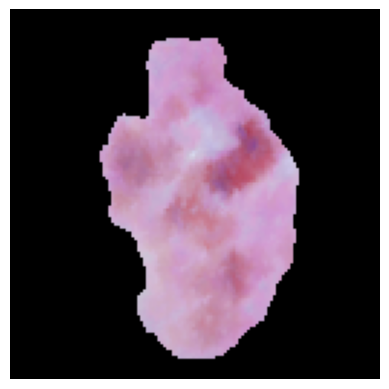

In [ ]:
# example usage to get a data point
image, binary_label, multiclass_label, row = dataset_q1[0]
# image here is in RGB format with width and height!
print(image.shape)
print(dataset_q1[0][0].shape) # another way of getting the first image
# visualizing the image
imshow(image)